In [1]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
tf.__version__

'2.10.1'

In [2]:
def get_efrosgas_dataset(dataset_name):
    dataset_file = f"{dataset_name}.tar.gz"
    dataset_url = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_file}"
    download_zip = tf.keras.utils.get_file(fname=dataset_file, origin=dataset_url, extract=True)
    download_zip = pathlib.Path(download_zip)
    path = download_zip.parent/dataset_name
    return path

In [3]:
dataset_name = 'maps'
dataset_path = get_efrosgas_dataset(dataset_name)

In [4]:
def load_image(img_file):
    img = tf.io.read_file(img_file)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [256, 512])

    width = tf.shape(img)[1]
    width = width // 2
    original_img = img[:, :width, :]
    transformed_img = img[:, width:, :]

    original_img = tf.cast(original_img, tf.float32)
    transformed_img = tf.cast(transformed_img, tf.float32)

    return original_img, transformed_img


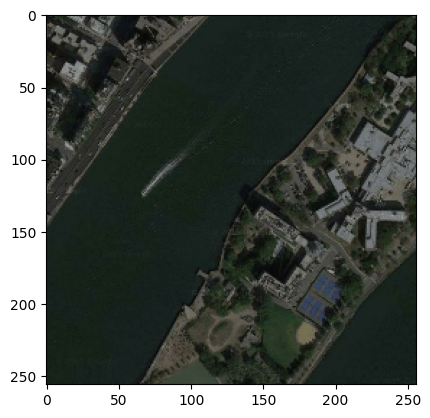

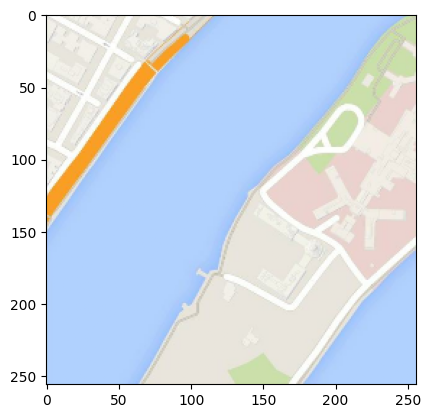

In [5]:
original_img, transformed_img = load_image(str(dataset_path/'train/3.jpg'))
plt.figure()
plt.imshow(original_img / 255.0)
plt.figure()
plt.imshow(transformed_img / 255.0);

In [6]:
quantity_training = tf.data.Dataset.list_files(str(dataset_path/'train/*.jpg'))
quantity_training = len(list(quantity_training))

In [7]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [8]:
def resize(original_img, transformed_img, width, height):
    original_img = tf.image.resize(original_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    transformed_img = tf.image.resize(transformed_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return original_img, transformed_img

In [9]:
def normalize(original_img, transformed_img):
    original_img = (original_img / 127.5) - 1
    transformed_img = (transformed_img / 127.5) - 1
    return original_img, transformed_img

In [10]:
def random_crop(original_img, transformed_img):
    stacked_img = tf.stack([original_img, transformed_img], axis=0)
    crop_img = tf.image.random_crop(stacked_img, size = [2, img_width, img_height, 3])
    return crop_img[0], crop_img[1]

In [11]:
@tf.function()
def random_jitter(original_img, transformed_img):
    original_img, transformed_img = resize(original_img, transformed_img, 286, 286)
    original_img, transformed_img = random_crop(original_img, transformed_img)
    if tf.random.uniform(())>0.5:
        original_img = tf.image.flip_left_right(original_img)
        transformed_img = tf.image.flip_left_right(transformed_img)
    return original_img, transformed_img

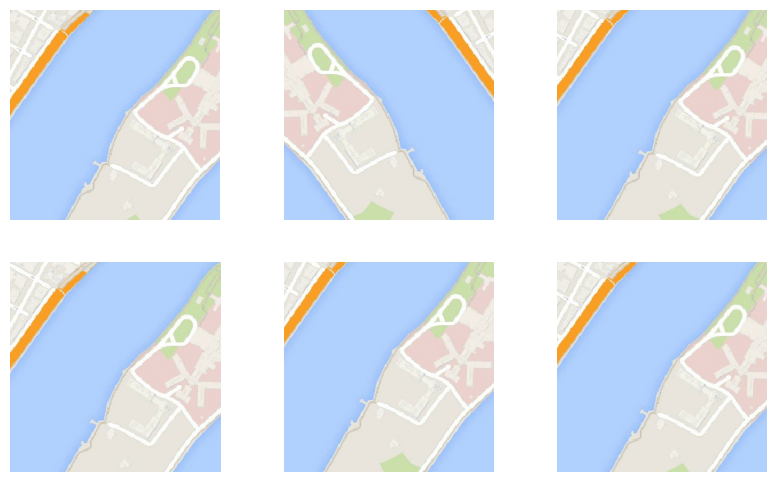

In [12]:
plt.figure(figsize = (10,6))
for i in range(6):
  j_original, j_transformed = random_jitter(original_img, transformed_img)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_transformed / 255.0)
  plt.axis('off')
plt.show()

In [13]:
def load_training_images(img_file):
    original_img, transformed_img = load_image(img_file)
    original_img, transformed_img = random_jitter(original_img, transformed_img)
    original_img, transformed_img = normalize(original_img, transformed_img)
    return original_img, transformed_img

In [14]:
def load_testing_images(img_file):
    original_img, transformed_img = load_image(img_file)
    original_img, transformed_img = resize(original_img, transformed_img, img_width, img_height)
    original_img, transformed_img = normalize(original_img, transformed_img)
    return original_img, transformed_img

In [15]:
training_dataset = tf.data.Dataset.list_files(str(dataset_path/'train/*.jpg'))
training_dataset = training_dataset.map(load_training_images, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(buffer_size)

In [16]:
try:
    testing_dataset = tf.data.Dataset.list_files(str(dataset_path/'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    testing_dataset = tf.data.Dataset.list_files(str(dataset_path/'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

In [17]:
def encode(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0, 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [18]:
down_model =encode(3, 4)
down_result = down_model(tf.expand_dims(original_img, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [19]:
def decode(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0, 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    return result

In [20]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [21]:
def Generator():
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])

    downsampling = [
      encode(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
      encode(128, 4), # (batch_size, 64, 64, 128)
      encode(256, 4), # (batch_size, 32, 32, 256)
      encode(512, 4), # (batch_size, 16, 16, 512)
      encode(512, 4), # (batch_size, 8, 8, 512)
      encode(512, 4), # (batch_size, 4, 4, 512)
      encode(512, 4), # (batch_size, 2, 2, 512)
      encode(512, 4), # (batch_size, 1, 1, 512)
    ]

    upsampling = [
      decode(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
      decode(512, 4), # (batch_size, 16, 16, 512)
      decode(256, 4), # (batch_size, 32, 32, 256)
      decode(128, 4), # (batch_size, 64, 64, 128)
      decode(64, 4), # (batch_size, 128, 128, 64)
    ]

    output_channels = 3
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (batch_size, 256, 256, 3)
    x = inputs
    skips = []
    for down in downsampling:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(upsampling, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)

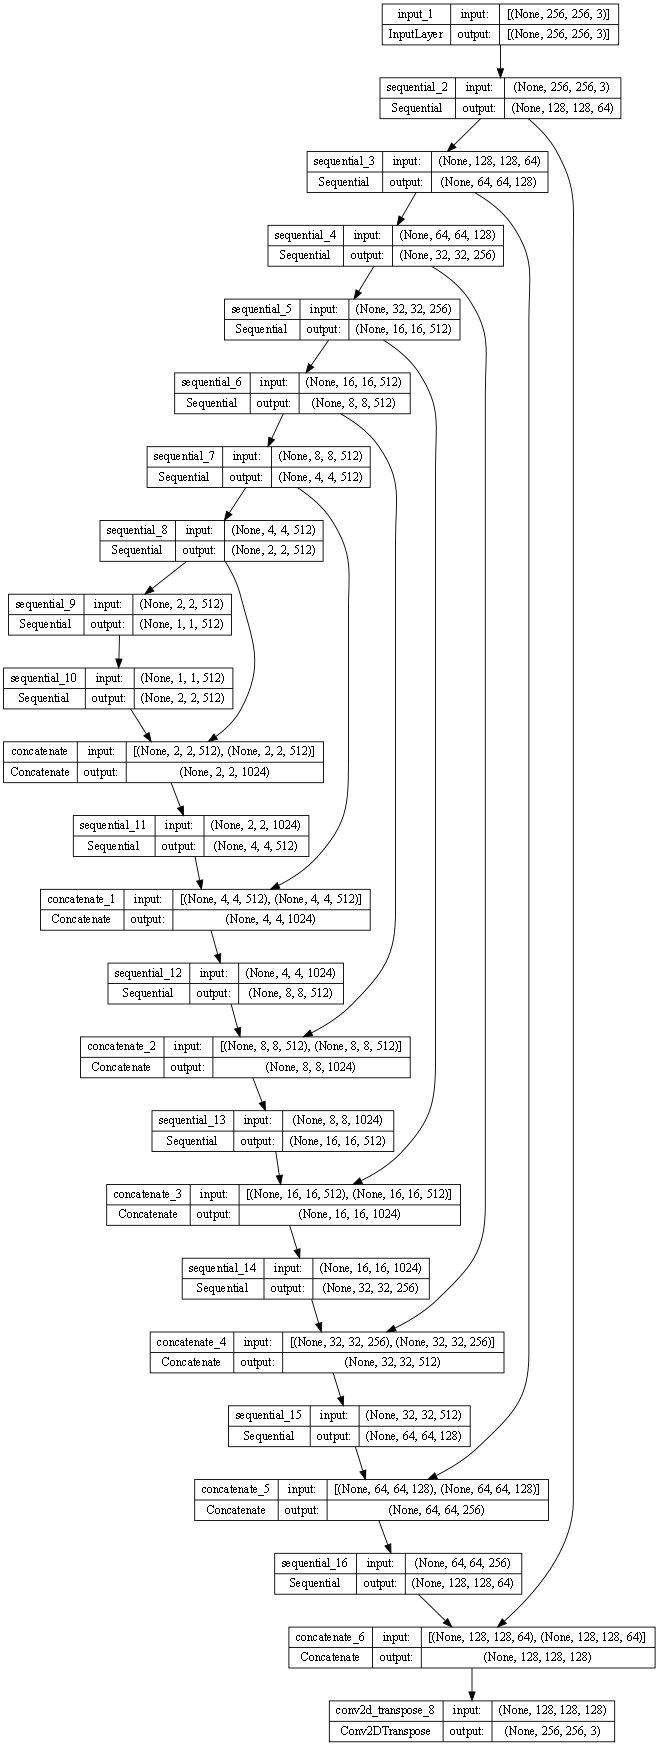

In [22]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


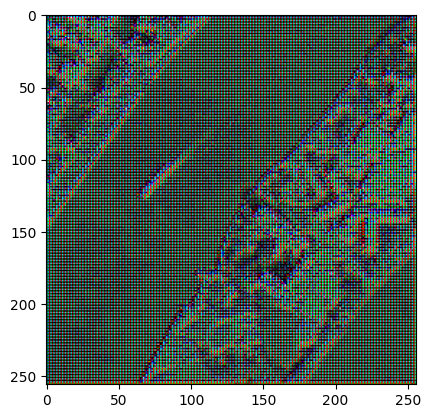

In [23]:
g_output = generator(original_img[tf.newaxis, ...], training=False)
plt.imshow(g_output[0, ...])

In [24]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [25]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [26]:
def generator_loss(d_generated_output, g_output, target):
    gan_loss = loss(tf.ones_like(d_generated_output), d_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # MAE
    g_loss_total = gan_loss + (lambda_ * l1_loss)
    return g_loss_total, gan_loss, l1_loss

In [27]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    original = tf.keras.layers.Input(shape = [256,256,3], name='original_img')
    transformed = tf.keras.layers.Input(shape=[256,256,3], name='transformed_img')
    x = tf.keras.layers.concatenate([original, transformed]) # (batch_size, 256, 256, channels * 2)

    down1 = encode(64, 4, False)(x) # (batch_size, 128, 128, 64)
    down2 = encode(128, 4)(down1) # (batch_size, 64, 64, 128)
    down3 = encode(256, 4)(down2) # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs = [original, transformed], outputs = last)

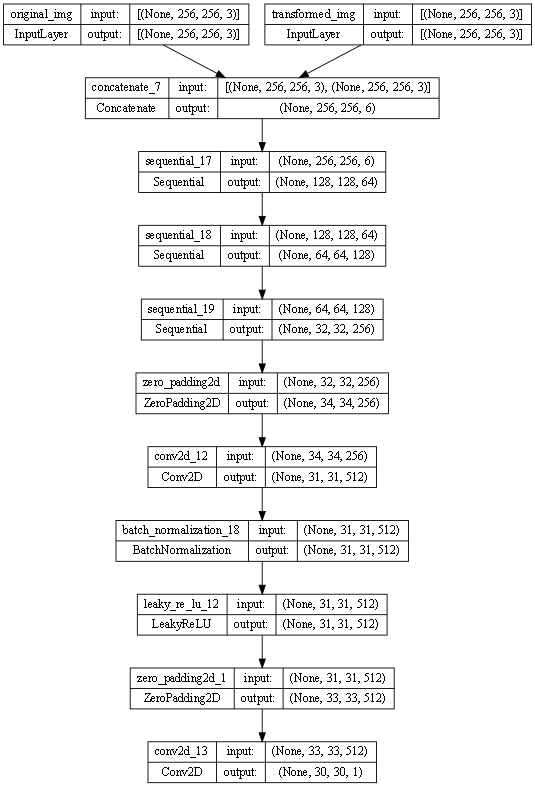

In [28]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 64)

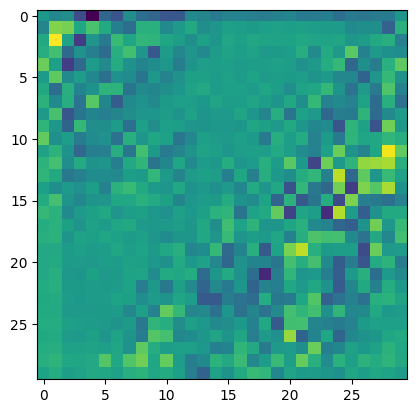

In [29]:
d_output = discriminator([original_img[tf.newaxis, ...], g_output], training=False)
plt.imshow(d_output[0, ..., -1])

In [30]:
def discriminator_loss(d_real_output, d_generated_output):
    real_loss = loss(tf.ones_like(d_real_output), d_real_output)
    generated_loss = loss(tf.zeros_like(d_generated_output), d_generated_output)
    d_total_loss = real_loss + generated_loss
    return d_total_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [32]:
def generate_images(model, test_input, real, step = None):
    generated_img = model(test_input, training=True)
    plt.figure(figsize=(12,8))

    img_list = [test_input[0], real[0], generated_img[0]]
    title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(img_list[i] * 0.5 + 0.5)
        plt.axis('off')

    if step is not None:
        plt.savefig('result_pix2pix_step_{}.png'.format(step), bbox_inches='tight')

    plt.show()

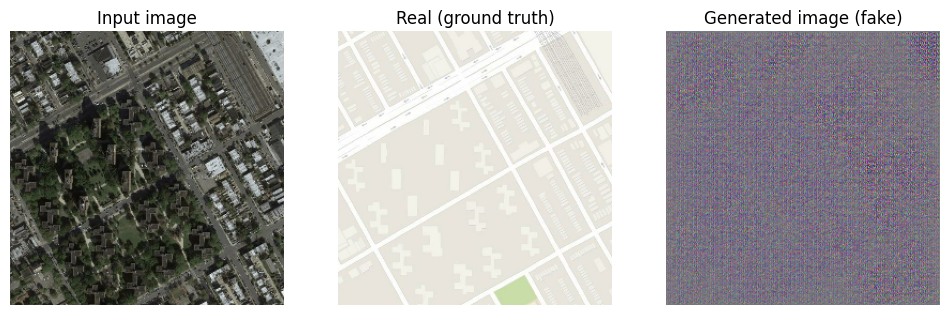

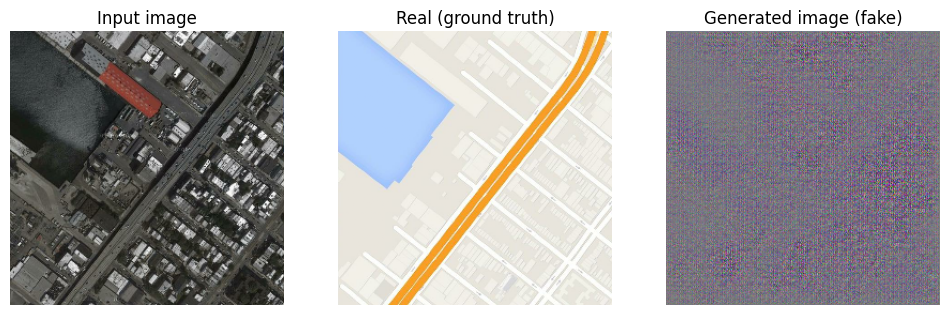

In [33]:
for input_example, real_example in testing_dataset.take(2):
  generate_images(generator, input_example, real_example)

In [34]:
path_log = 'logs/'
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [35]:
@tf.function
def training_step(input_img, real, step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)

    d_output_real = discriminator([input_img, real], training = True)
    d_output_generated = discriminator([input_img, g_output], training = True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_generated, g_output, real)
    d_loss = discriminator_loss(d_output_real, d_output_generated)

  generator_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with metrics.as_default():
    tf.summary.scalar('g_total_loss', g_total_loss, step=step//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=step//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=step//1000)
    tf.summary.scalar('d_loss', d_loss, step=step//1000)

In [36]:
def train(training_dataset, testing_dataset, steps):
    test_input, real_input = next(iter(testing_dataset.take(1)))
    start = time.time()

    for step_tensor, (input_img, real_img) in training_dataset.repeat().take(steps).enumerate():
        step = step_tensor.numpy()
        if step % 1000 == 0:
            display.clear_output(wait = True)
            if step != 0:
                print(f'Time taken to run 1000 steps: {time.time() - start:.2f} seconds\n')
            start = time.time()
            generate_images(generator, test_input, real_input, step)
            print(f'Step: {step//1000}K')
        training_step(input_img, real_img, step)
        if (step + 1) % 10 == 0:
            print('.', end = '', flush = True)
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            generator.save_weights('model_pix2pix.h5')

In [37]:
# %reload_ext tensorboard
# %tensorboard --logdir {path_log}

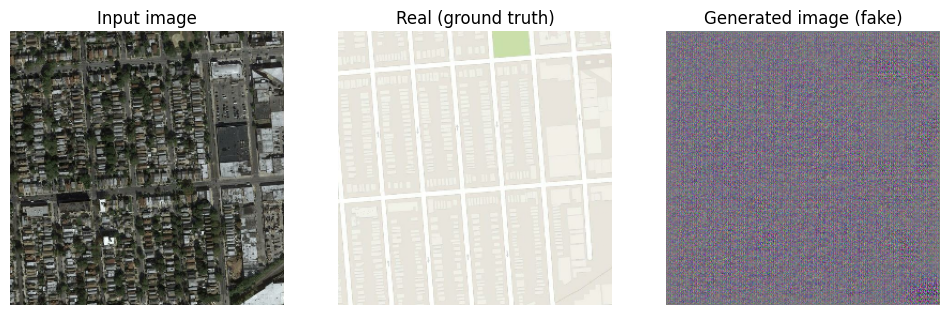

Step: 0K


ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;146db8e415ebe3d9;/job:localhost/replica:0/task:0/device:GPU:0;edge_105_real;0:0
	 [[{{node real/_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[binary_crossentropy/weighted_loss/value/_8]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;146db8e415ebe3d9;/job:localhost/replica:0/task:0/device:GPU:0;edge_105_real;0:0
	 [[{{node real/_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_training_step_9618]

In [38]:
train(training_dataset, testing_dataset, steps = 2000) # 40000